In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir, load_yaml
from aimanager.utils.array_to_df import using_multiindex, add_labels
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

run = '11_features'

folder = f'../../data/manager_v3/{run}'

train_folder = os.path.join(folder, 'metrics')
merge_file = os.path.join(folder, 'metrics.parquet')
model_folder = os.path.join(folder, 'model')

plot_folder = f'plots/{run}'

make_dir(plot_folder)

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# if not os.path.isfile(merge_file):
#     dfs = [pd.read_parquet(os.path.join(train_folder, file)) for file in os.listdir(train_folder)]
#     df = pd.concat(dfs)
#     df.to_parquet(merge_file)
# else:
#     df = pd.read_parquet(merge_file)
dfs = [pd.read_parquet(os.path.join(train_folder, file)) for file in os.listdir(train_folder)]
df = pd.concat(dfs)

In [3]:
df.columns

Index(['artificial_humans', 'features', 'lr', 'model', 'target_update_freq',
       'job_id', 'round_number', 'sampling', 'update_step', 'metric', 'value'],
      dtype='object')

In [4]:
non_labels = ['round_number', 'sampling', 'update_step', 'metric', 'value', 'job_id']

labels = [c for c in df.columns if c not in non_labels]


In [5]:
labels

['artificial_humans', 'features', 'lr', 'model', 'target_update_freq']

In [6]:
df['metric'].unique()

array(['punishments', 'contributions', 'common_good',
       'contributor_payoff', 'manager_payoff', 'next_reward', 'q_min',
       'q_max', 'q_mean', 'loss'], dtype=object)

In [11]:
import statsmodels.formula.api as smf
res = []
for ah in df['artificial_humans'].unique():
    for m in df['model'].unique():

        w = (
            (df['metric'] == 'common_good') &
            (df['sampling'] == 'greedy')&
            (df['artificial_humans'] == ah)&
            (df['model'] == m)
        )
        dfs = df[w].copy()
        w_max = (dfs['update_step'] > (0.8 * dfs['update_step'].max()))
        dfs = dfs[w_max].copy()

        for l in labels:
            dfs[l] = dfs[l].astype(str)


        label_ref = {
            'eps': '0.1',
            'gamma': '1.0',
            'lr': '3.e-4',
            'memory_episodes': '100',
            'target_update_freq': '200',
            'hidden_size': '5',
            'features': 'contributions'
        }


        label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]


        results = smf.glm(f"value ~ {'+'.join(label_str)}", data=dfs).fit()
        results_df = results.summary2().tables[1]
        results_df['artificial_humans'] = ah
        results_df['model'] = m
        res.append(results_df)
        # print('metric accuracy - positive coef -> better')
        # results_df[results_df['P>|z|'] < 0.25].sort_values('P>|z|')
        # print(f'{ah} | {m}')
        # print(results_df)
results_df = pd.concat(res)


results_df = results_df.reset_index()
results_df

,index,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],artificial_humans,model
0,Intercept,21.982114,0.077670,283.018936,0.000000e+00,21.829884,22.134345,simple,mlp
1,"C(features, Treatment(reference='contributions...",-0.848938,0.092834,-9.144731,5.977859e-20,-1.030888,-0.666987,simple,mlp
2,"C(features, Treatment(reference='contributions...",0.552427,0.092834,5.950724,2.669585e-09,0.370476,0.734377,simple,mlp
3,"C(features, Treatment(reference='contributions...",0.024496,0.092834,0.263873,7.918781e-01,-0.157454,0.206447,simple,mlp
4,"C(features, Treatment(reference='contributions...",0.561741,0.092834,6.051058,1.438974e-09,0.379791,0.743692,simple,mlp
5,"C(lr, Treatment(reference='3.e-4'))[T.1.e-4]",-2.179851,0.058713,-37.127170,1.024141e-301,-2.294926,-2.064775,simple,mlp
6,"C(target_update_freq, Treatment(reference='200...",-1.018636,0.058713,-17.349384,1.993693e-67,-1.133712,-0.903560,simple,mlp
7,Intercept,23.172731,0.085666,270.501092,0.000000e+00,23.004829,23.340633,simple,rnn_edge
8,"C(features, Treatment(reference='contributions...",-0.682741,0.102390,-6.668019,2.592792e-11,-0.883423,-0.482060,simple,rnn_edge
9,"C(features, Treatment(reference='contributions...",0.037315,0.102390,0.364443,7.155271e-01,-0.163366,0.237997,simple,rnn_edge


/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


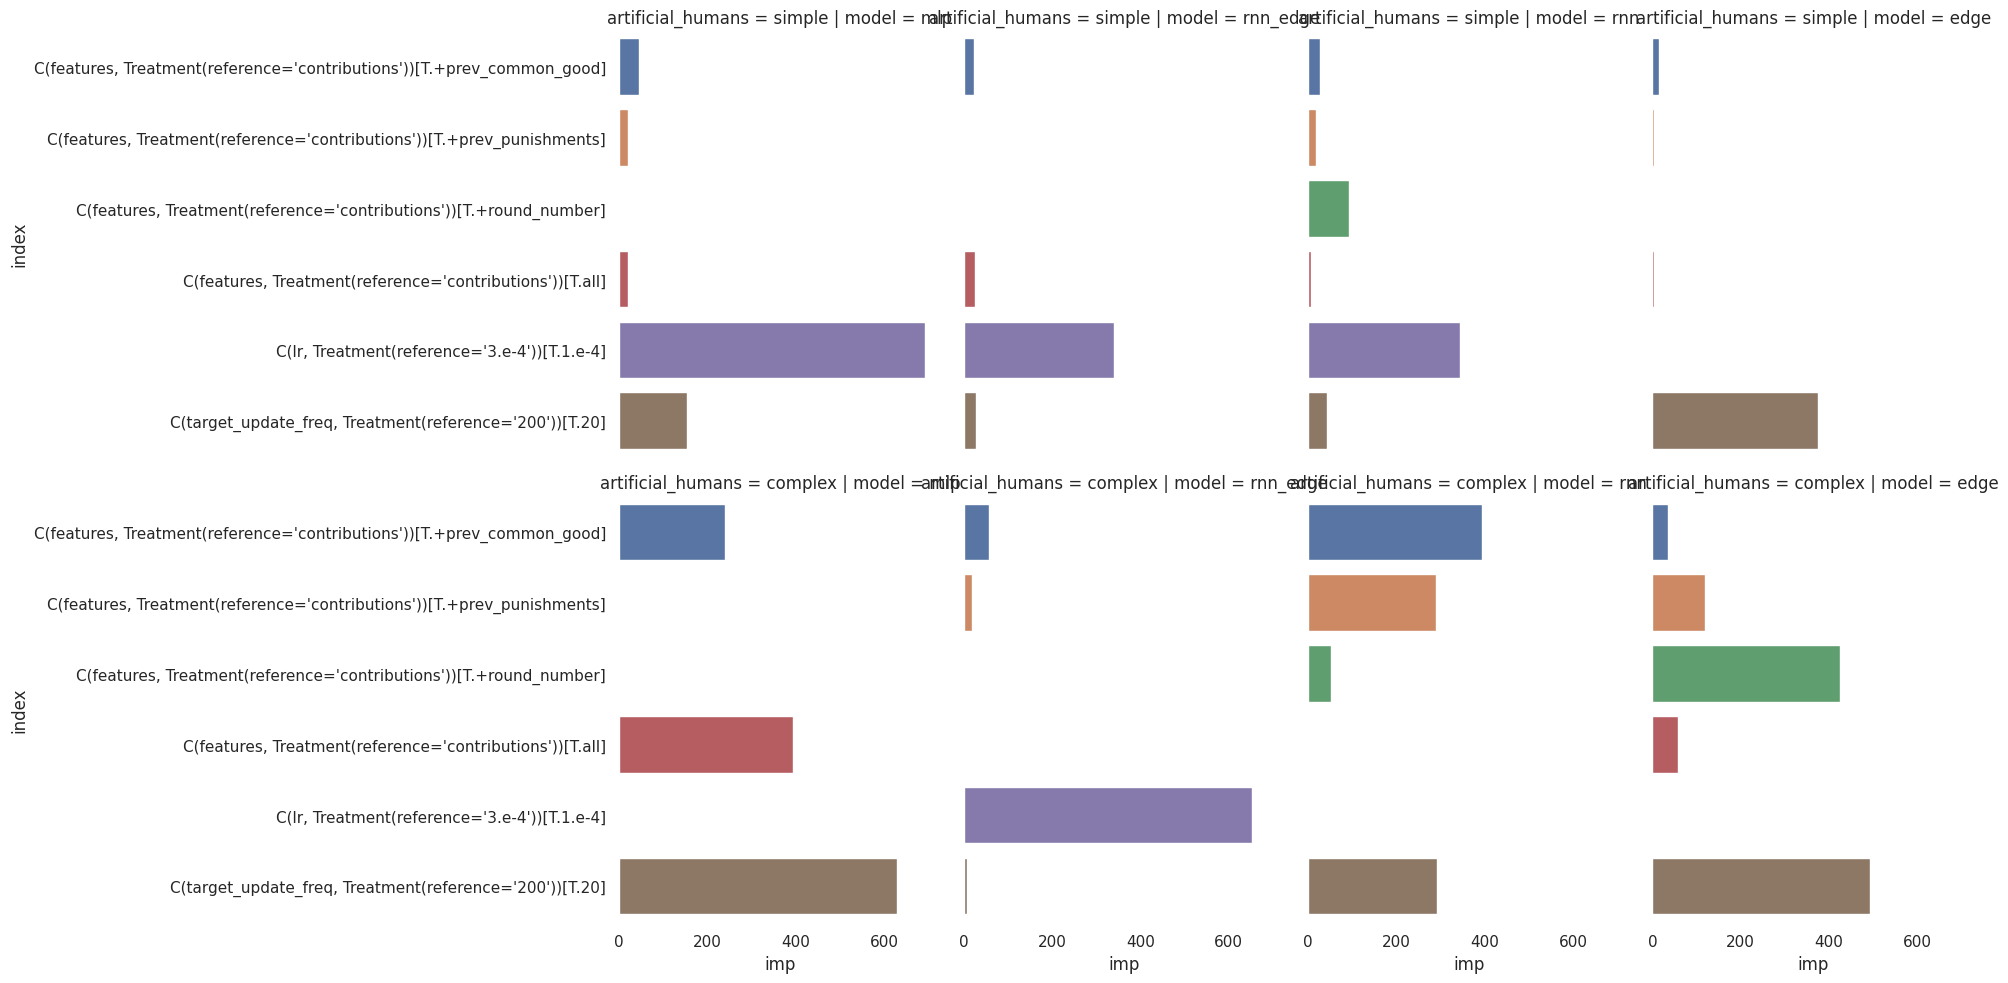

In [12]:
results_df['imp'] = - np.log(results_df['P>|z|'])

sns.catplot(data=results_df[results_df['index'] != 'Intercept'], x='imp', y='index', col='model', row='artificial_humans', kind='bar')

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


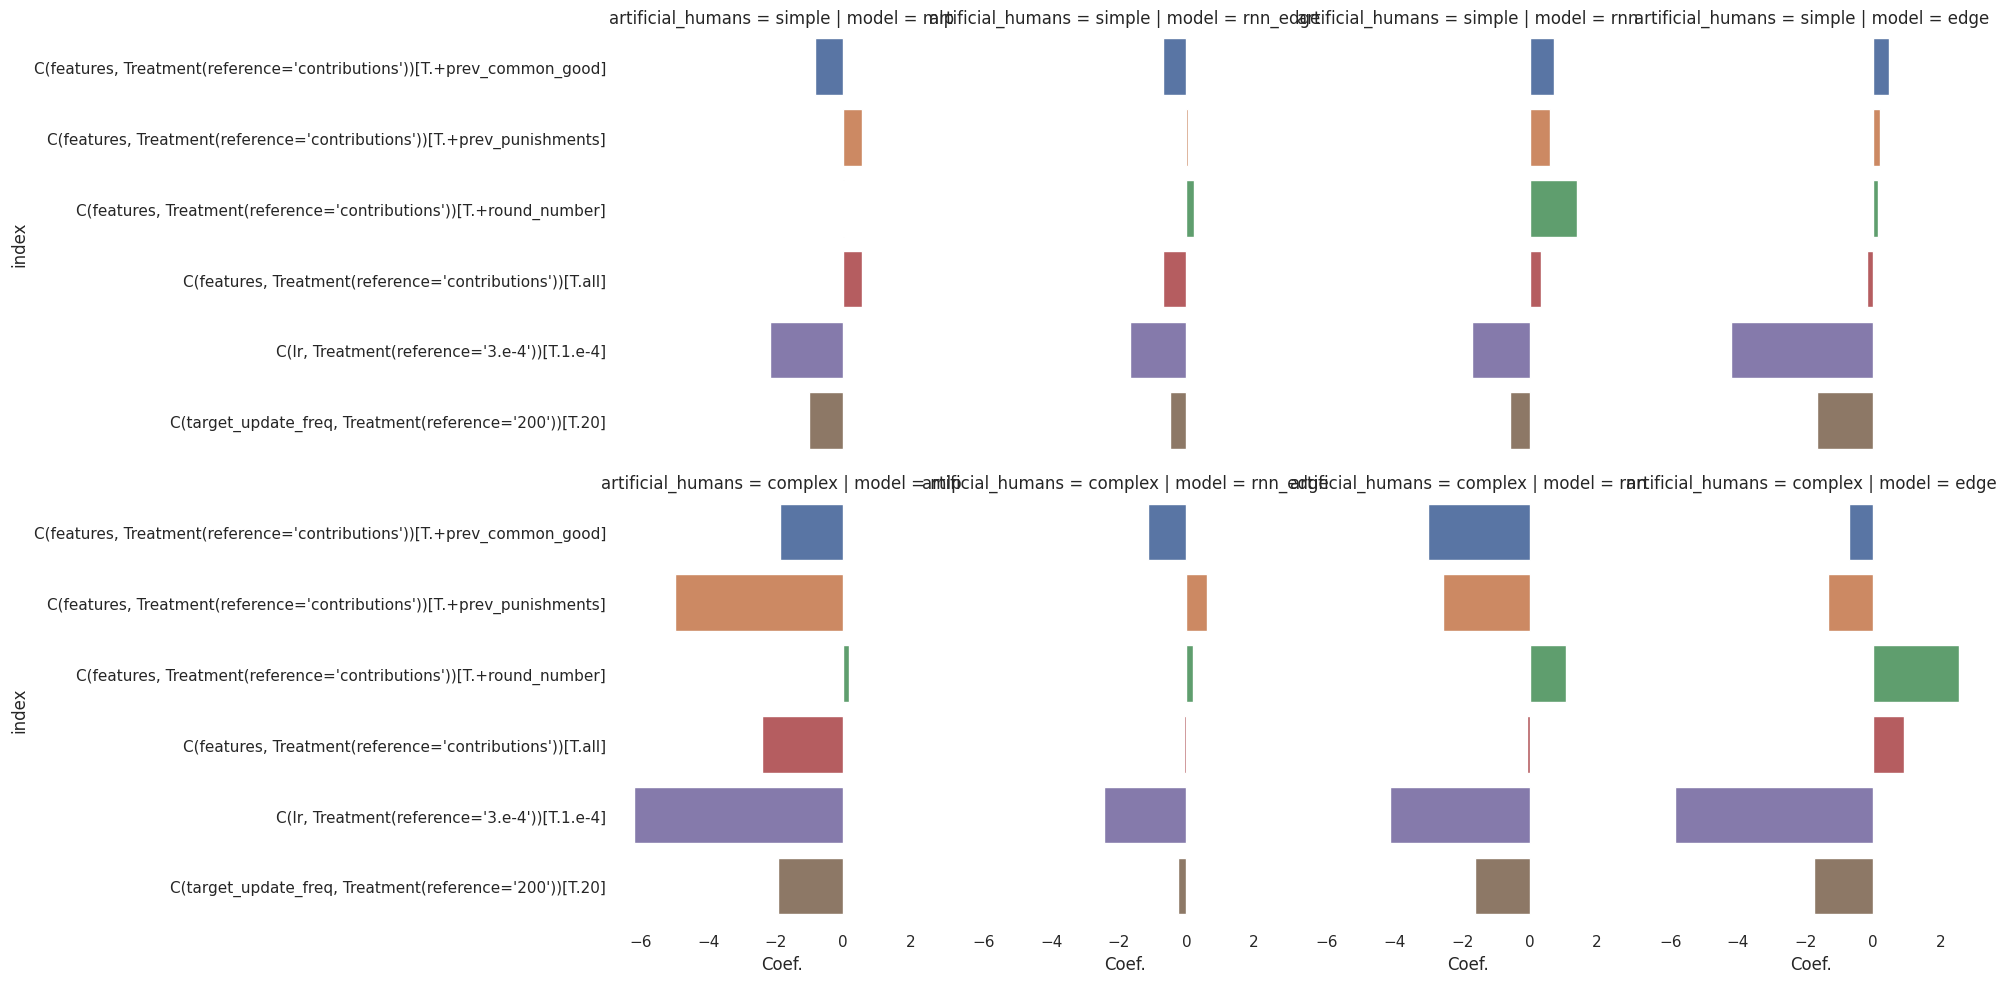

In [13]:
results_df['imp'] = - np.log(results_df['P>|z|'])

sns.catplot(data=results_df[results_df['index'] != 'Intercept'], x='Coef.', y='index', col='model', row='artificial_humans', kind='bar')

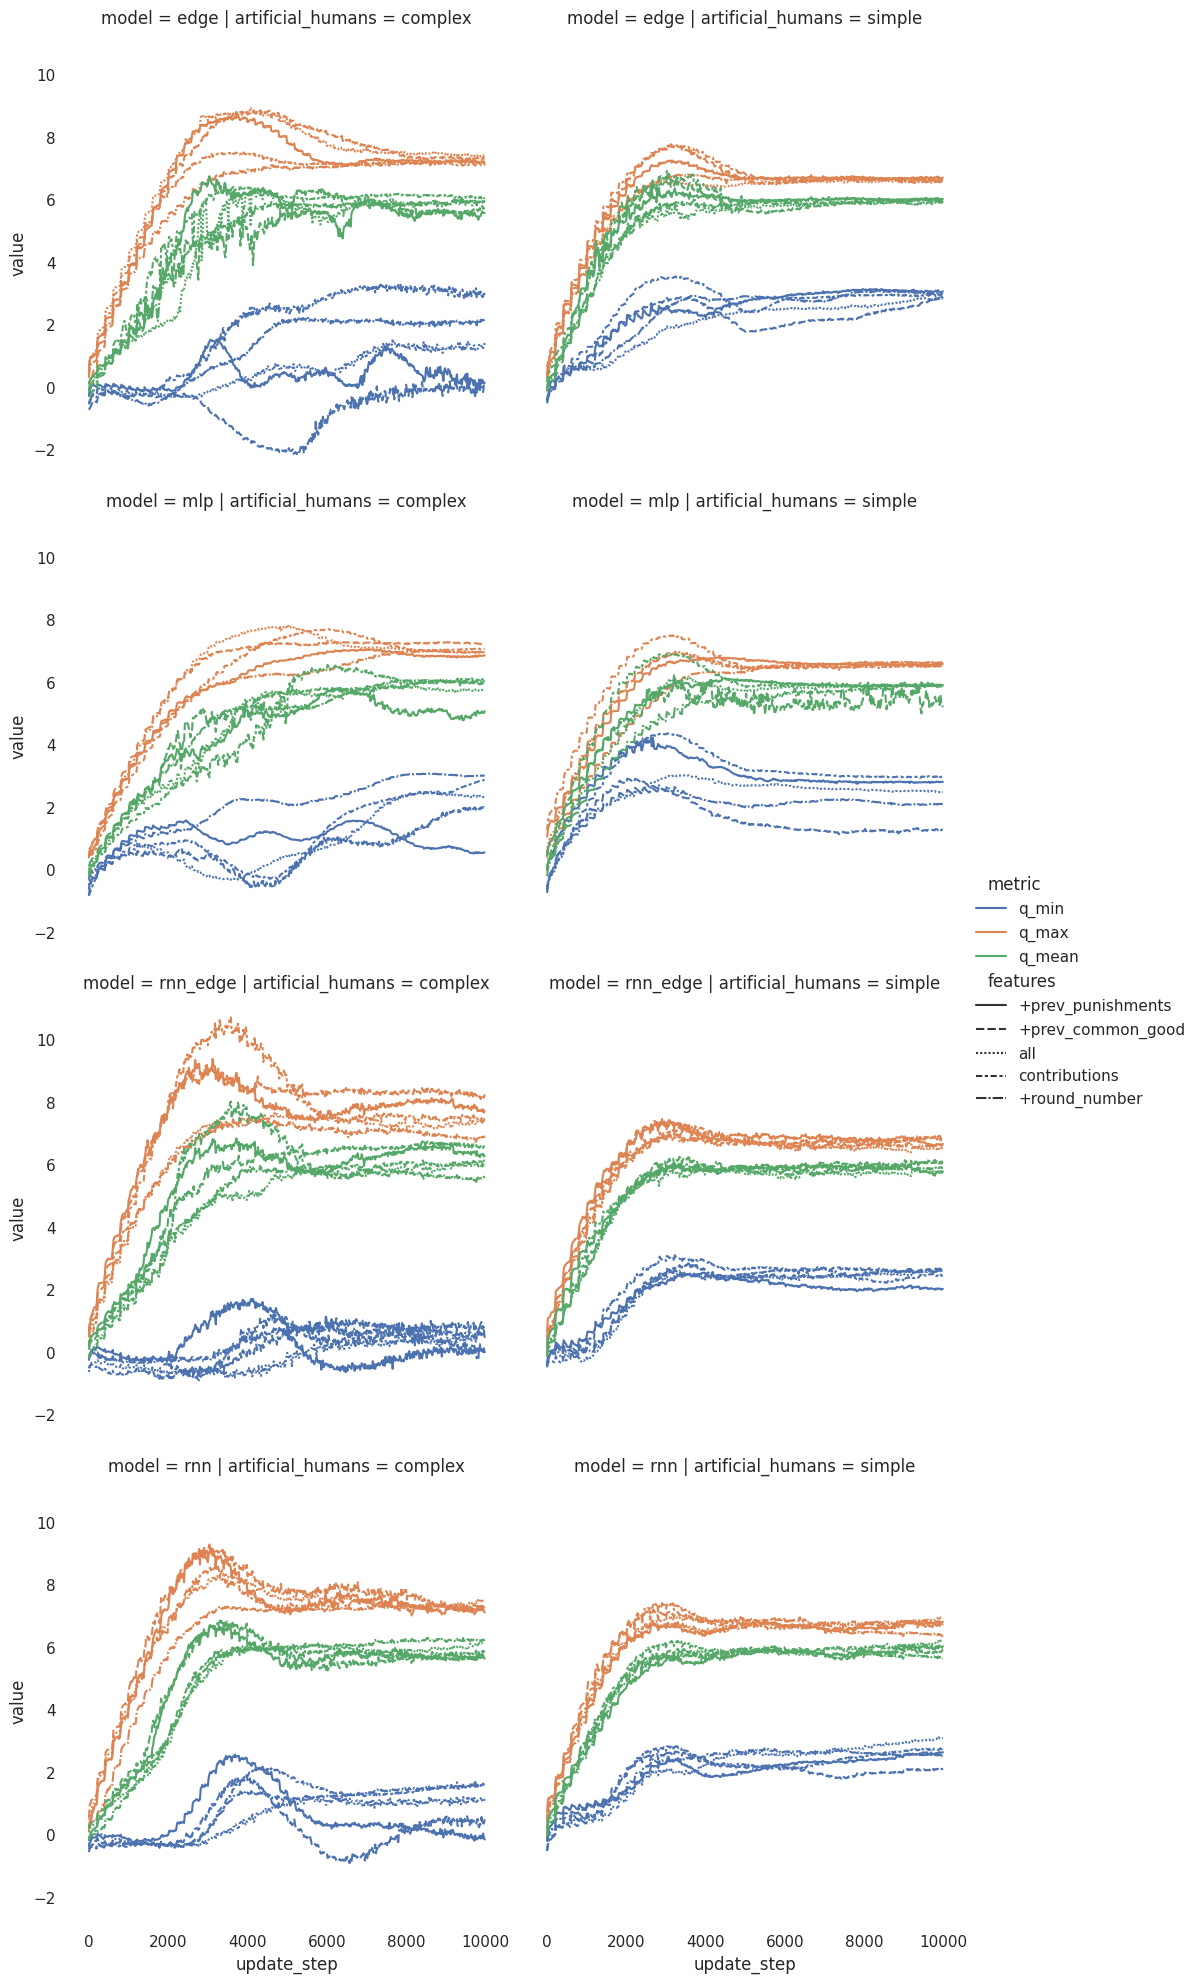

In [20]:
selection = {'eps': 0.2, 'gamma': 1, 'hidden_size': 20, 'lr': '3.e-4', 'memory_episodes': 100, 'sampling': 'greedy', 'target_update_freq': 200, 'features': 'contributions'}

focus = ['update_step', 'metric', 'features', 'artificial_humans', 'model']

# selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['q_min', 'q_max', 'q_mean'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)


fg.savefig(os.path.join(plot_folder, 'q_values.jpg'))

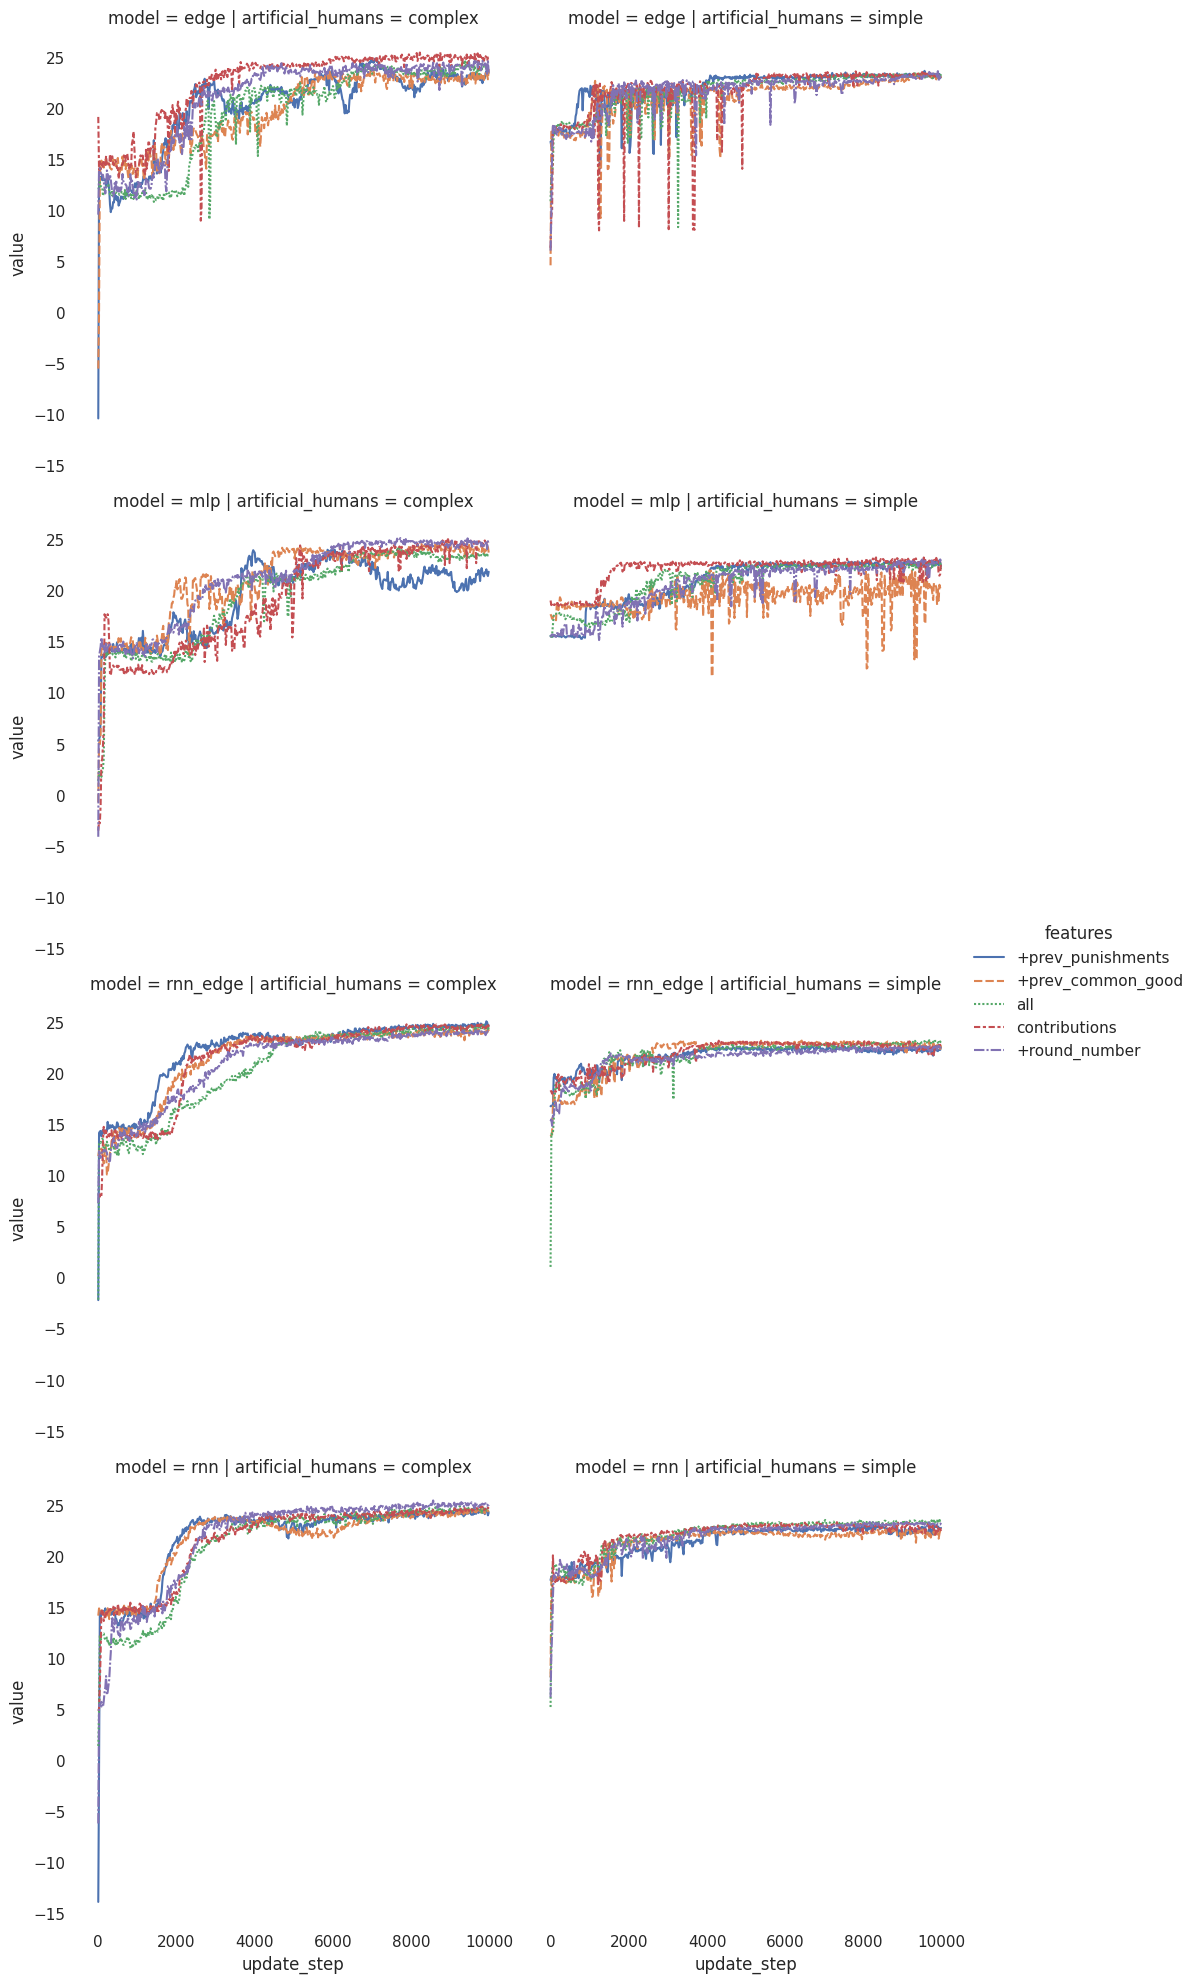

In [21]:
focus = ['update_step', 'features', 'features', 'artificial_humans', 'model']

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['common_good'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)


fg.savefig(os.path.join(plot_folder, 'q_values.jpg'))

<AxesSubplot:xlabel='artificial_humans', ylabel='value'>

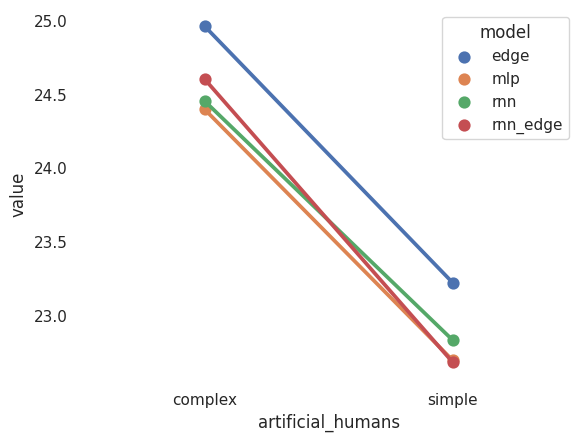

In [22]:
focus = ['update_step', 'artificial_humans', 'model']

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['common_good'])
dfs = dfs[w]

w_max = (dfs['update_step'] > (0.8 * dfs['update_step'].max()))
dfs = dfs[w_max].copy()

dfs = dfs.groupby(labels)['value'].mean().reset_index()

sns.pointplot(data=dfs, y='value', hue='model', x='artificial_humans')

<AxesSubplot:xlabel='artificial_humans', ylabel='value'>

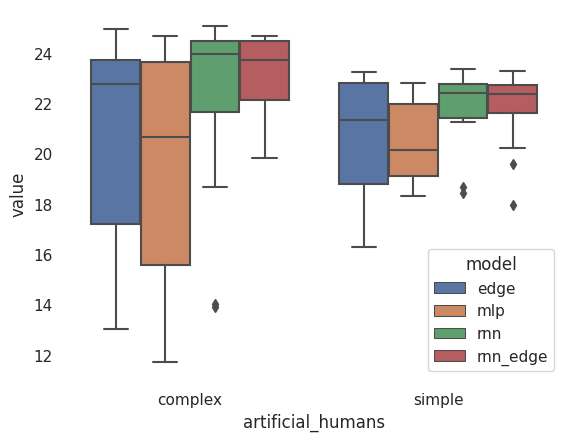

In [23]:
w = (
    (df['metric'] == 'common_good') &
    (df['sampling'] == 'greedy')
)
dfs = df[w].copy()
w_max = (dfs['update_step'] > (0.8 * dfs['update_step'].max()))
dfs = dfs[w_max].copy()

dfs = dfs.groupby(labels)['value'].mean().reset_index()

sns.boxplot(data=dfs, y='value', hue='model', x='artificial_humans')